In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pycaret.regression 
import pycaret.clustering
import pycaret.classification
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score
import seaborn as sns
import datetime
from helper_functions import *
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
%matplotlib inline

# 0. Data import

We will use the NY Stock Exchange data for training, and the Berlin data for testing. That way we will ensure that the model is useful to be extrapolated to different indexes and stocks. 

In [15]:
data_NY = import_index_data(symbol="NYA")
data_DE = import_index_data(symbol="GDAXI")

In [16]:
data_NY.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13948 entries, 0 to 13947
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    13948 non-null  datetime64[ns]
 1   Close   13948 non-null  float64       
 2   Volume  13948 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 327.0 KB


In [17]:
data_train = create_modeling_df(data_NY, 400, snippet_size=20, projection_step=30, scaling ="minmax")
data_test = create_modeling_df(data_DE, 100, snippet_size=20, projection_step=30, scaling ="minmax")

In [79]:
X_train = data_train.drop(columns=["Pivot_date", "Target_value"])
X_test = data_test.drop(columns=["Pivot_date", "Target_value"])
y_train = data_train["Target_value"]
y_test = data_test["Target_value"]

In [19]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(400, 41) (100, 41) (400,) (100,)


# 1. Trends clustering model

First we have to drop the final value (pivot value) so the clustering model receives only the normalized trend data.

In [80]:
X_cluster_train = X_train.drop(columns=["Pivot_value"])
X_cluster_test = X_test.drop(columns=["Pivot_value"])

We will use custom functions to calculate an elbow and silhouette graph:

Trained a K-Means model with 2 neighbours! Time needed = 0.025 seconds.
Trained a K-Means model with 4 neighbours! Time needed = 0.037 seconds.
Trained a K-Means model with 6 neighbours! Time needed = 0.043 seconds.
Trained a K-Means model with 8 neighbours! Time needed = 0.045 seconds.
Trained a K-Means model with 10 neighbours! Time needed = 0.056 seconds.
Trained a K-Means model with 12 neighbours! Time needed = 0.061 seconds.
Trained a K-Means model with 14 neighbours! Time needed = 0.062 seconds.
Trained a K-Means model with 16 neighbours! Time needed = 0.073 seconds.
Trained a K-Means model with 18 neighbours! Time needed = 0.072 seconds.
Trained a K-Means model with 20 neighbours! Time needed = 0.076 seconds.
Trained a K-Means model with 22 neighbours! Time needed = 0.083 seconds.
Trained a K-Means model with 24 neighbours! Time needed = 0.081 seconds.
Trained a K-Means model with 26 neighbours! Time needed = 0.087 seconds.
Trained a K-Means model with 28 neighbours! Time needed

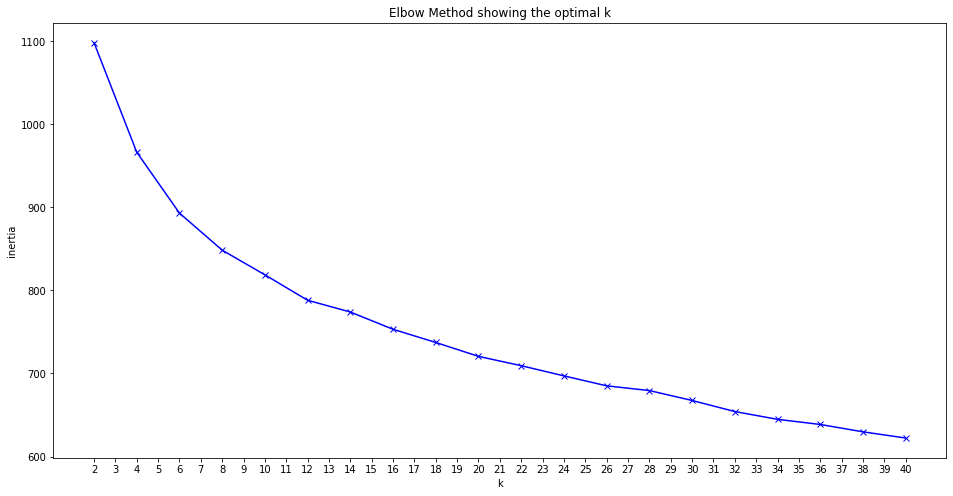

0

In [21]:
elbow_graph(X_cluster_train)

Calculated silhouette with 2 neighbours! Time needed = 0.033 seconds.
Calculated silhouette with 4 neighbours! Time needed = 0.047 seconds.
Calculated silhouette with 6 neighbours! Time needed = 0.045 seconds.
Calculated silhouette with 8 neighbours! Time needed = 0.052 seconds.
Calculated silhouette with 10 neighbours! Time needed = 0.061 seconds.
Calculated silhouette with 12 neighbours! Time needed = 0.068 seconds.
Calculated silhouette with 14 neighbours! Time needed = 0.066 seconds.
Calculated silhouette with 16 neighbours! Time needed = 0.077 seconds.
Calculated silhouette with 18 neighbours! Time needed = 0.080 seconds.
Calculated silhouette with 20 neighbours! Time needed = 0.078 seconds.
Calculated silhouette with 22 neighbours! Time needed = 0.085 seconds.
Calculated silhouette with 24 neighbours! Time needed = 0.093 seconds.
Calculated silhouette with 26 neighbours! Time needed = 0.091 seconds.
Calculated silhouette with 28 neighbours! Time needed = 0.094 seconds.
Calculated

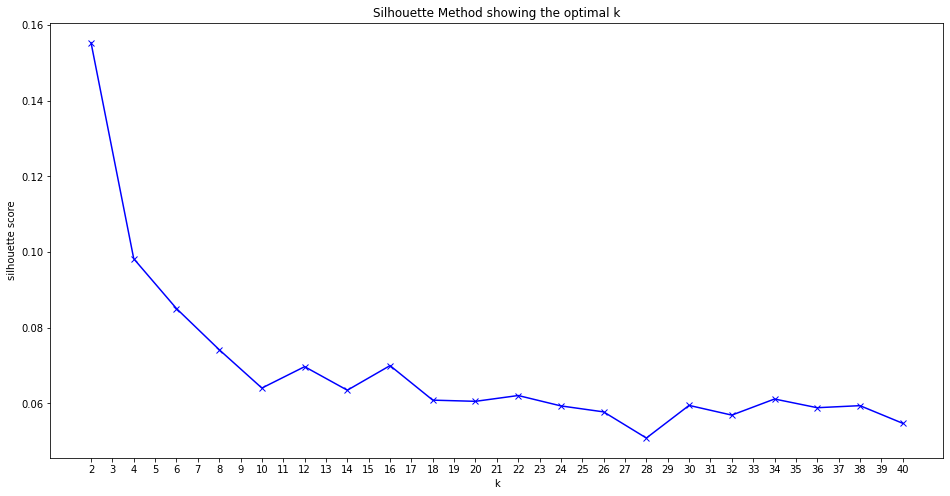

In [22]:
silhouette_graph(X_cluster_train)

We will create 15 clusters, one for each main trend. Next, we will train a model with our training data and visualise the trends that the clustering is trying to capture.

In [81]:
clustering_model = KMeans(init="k-means++", n_clusters=15)

In [82]:
#We fit the Kmeans to the training data
clustering_model.fit(X_cluster_train)

#We create the arrays with the predicted clusters, for the training and test data
clusters_train = clustering_model.predict(X_cluster_train)
clusters_test = clustering_model.predict(X_cluster_test)

#We incorporate the clusters to the training and test dataframes, and cast them to objects
X_train["Cluster"] = clusters_train
X_test["Cluster"] = clusters_test
X_train["Cluster"]= X_train["Cluster"].astype(object)
X_test["Cluster"]= X_test["Cluster"].astype(object)

In [25]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 42 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Vol0         400 non-null    float64
 1   Vol1         400 non-null    float64
 2   Vol2         400 non-null    float64
 3   Vol3         400 non-null    float64
 4   Vol4         400 non-null    float64
 5   Vol5         400 non-null    float64
 6   Vol6         400 non-null    float64
 7   Vol7         400 non-null    float64
 8   Vol8         400 non-null    float64
 9   Vol9         400 non-null    float64
 10  Vol10        400 non-null    float64
 11  Vol11        400 non-null    float64
 12  Vol12        400 non-null    float64
 13  Vol13        400 non-null    float64
 14  Vol14        400 non-null    float64
 15  Vol15        400 non-null    float64
 16  Vol16        400 non-null    float64
 17  Vol17        400 non-null    float64
 18  Vol18        400 non-null    float64
 19  Vol19   

Now we try to visualise what the clustering model does:
1. With a PCA decomposition
2. Visualising some trends for each cluster, and see if they seem related.

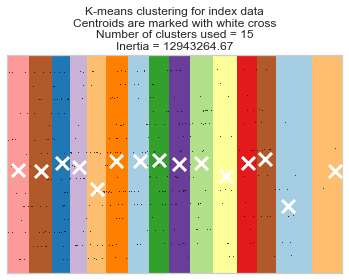

In [83]:
visualise_model(X_train, init_algo="k-means++", n_clusters=15, n_init=4)

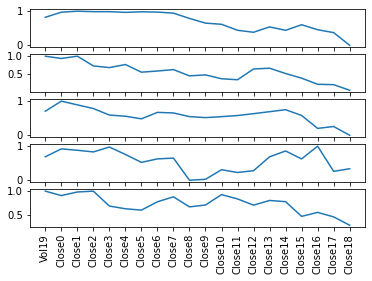

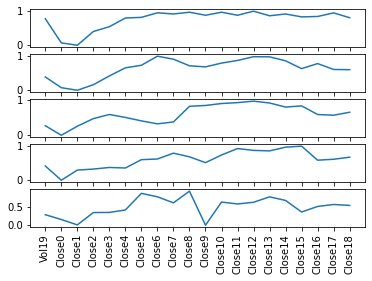

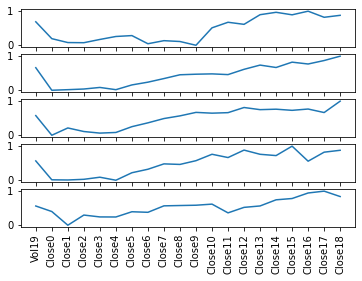

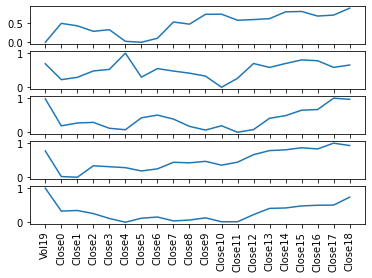

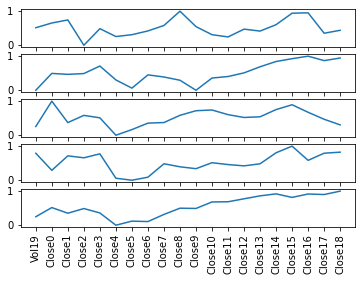

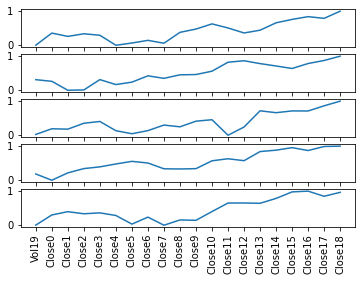

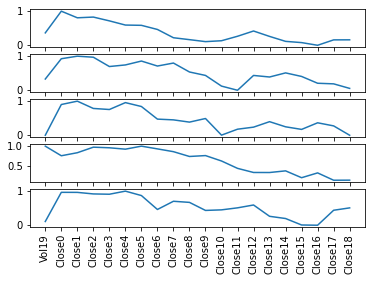

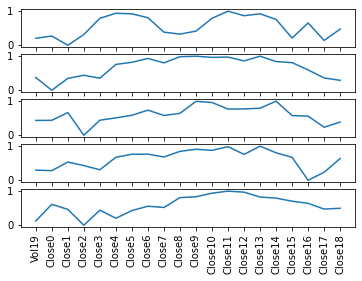

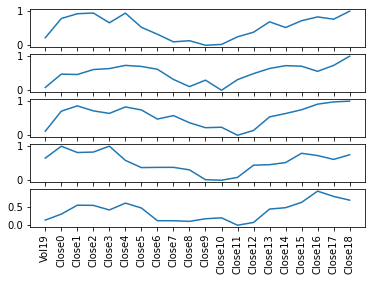

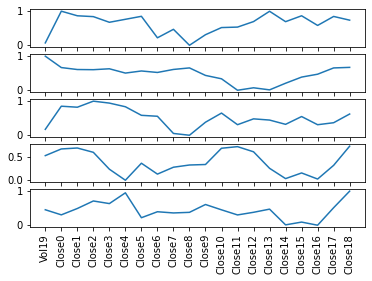

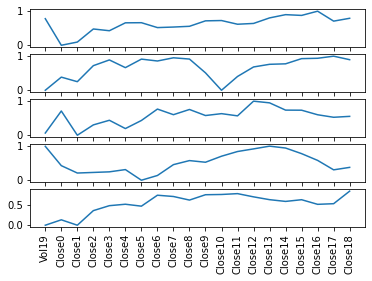

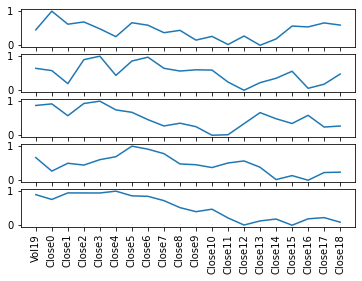

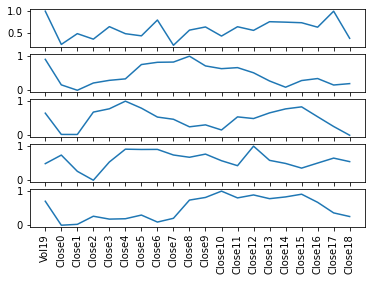

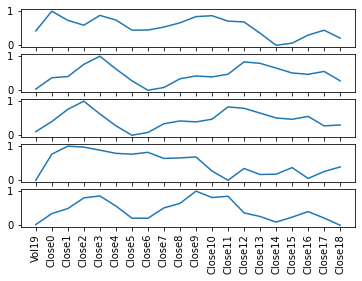

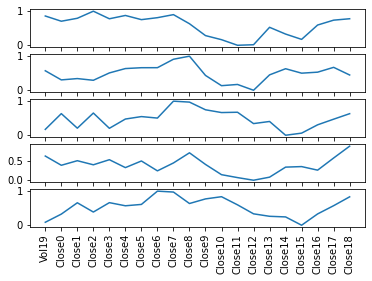

In [27]:
visualise_clusters(X_train, n_per_cluster=5)

# 2. Regression model using clustering results

Now we will use a tool called Pycaret to study which regression models are more useful. We will have several scenarios:
1. Passing all the information, including price, volumes and clusters, as well as pivot value, to the model.
2. Only passing the calculated clusters, together with the pivot value.
3. Passing the volume information, the calculated clusters, and the pivot value.

## 2.1 All the information

In [84]:
regression_data_1 = X_train.copy()
regression_data_1["Target_value"] = y_train

In [85]:
regression_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 43 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Vol0          400 non-null    float64
 1   Vol1          400 non-null    float64
 2   Vol2          400 non-null    float64
 3   Vol3          400 non-null    float64
 4   Vol4          400 non-null    float64
 5   Vol5          400 non-null    float64
 6   Vol6          400 non-null    float64
 7   Vol7          400 non-null    float64
 8   Vol8          400 non-null    float64
 9   Vol9          400 non-null    float64
 10  Vol10         400 non-null    float64
 11  Vol11         400 non-null    float64
 12  Vol12         400 non-null    float64
 13  Vol13         400 non-null    float64
 14  Vol14         400 non-null    float64
 15  Vol15         400 non-null    float64
 16  Vol16         400 non-null    float64
 17  Vol17         400 non-null    float64
 18  Vol18         400 non-null    

In [86]:
reg1 = pycaret.regression.setup(regression_data_1, target = "Target_value", 
                                remove_perfect_collinearity=False) #log_experiment=True, experiment_name='first_trial')

,Description,Value
0,session_id,4596
1,Target,Target_value
2,Original Data,"(400, 43)"
3,Missing Values,False
4,Numeric Features,41
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(279, 56)"


In [87]:
best = pycaret.regression.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,412.3937,384491.9454,597.0762,0.9343,0.0647,0.0477,0.0140
et,Extra Trees Regressor,378.3604,384618.1754,583.3876,0.9313,0.0626,0.0433,0.1620
gbr,Gradient Boosting Regressor,408.3369,403461.5001,606.3940,0.9263,0.0663,0.0475,0.0450
en,Elastic Net,418.4808,387105.8180,583.9030,0.9251,0.0645,0.0484,0.0070
par,Passive Aggressive Regressor,397.1431,378127.4536,577.9057,0.9251,0.0639,0.0465,0.0070
br,Bayesian Ridge,414.8844,386069.6592,583.4668,0.9250,0.0639,0.0477,0.0060
knn,K Neighbors Regressor,430.8502,443820.1516,639.9165,0.9244,0.0676,0.0487,0.0350
llar,Lasso Least Angle Regression,433.0453,406794.1727,602.2463,0.9232,0.0678,0.0509,0.0120
huber,Huber Regressor,389.7160,385168.5280,577.5244,0.9225,0.0636,0.0456,0.0060
omp,Orthogonal Matching Pursuit,430.5549,408738.8431,602.6930,0.9214,0.0673,0.0505,0.0050


Let's analyse the model's results:

In [88]:
model = pycaret.regression.create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,350.6549,416928.5968,645.7001,0.9525,0.0574,0.0366
1,462.8844,362866.1302,602.3837,0.9104,0.0682,0.0536
2,393.4639,295088.4840,543.2205,0.9587,0.0771,0.0549
3,238.0439,90091.2437,300.1520,0.9806,0.0341,0.0269
4,545.8168,811490.3810,900.8276,0.8132,0.0907,0.0651
5,496.5522,711351.7276,843.4167,0.9238,0.0678,0.0479
6,522.9545,395420.4283,628.8246,0.9450,0.0803,0.0630
7,372.7607,313364.6372,559.7898,0.9502,0.0644,0.0430
8,348.2754,210171.3584,458.4445,0.9442,0.0507,0.0398
9,392.5298,238146.4667,488.0025,0.9643,0.0562,0.0465


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

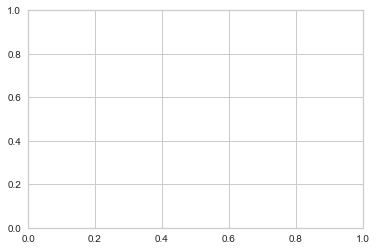

In [89]:
pycaret.regression.evaluate_model(model)

We will tune the model's hyperparameters and finalise it, that is, train it with the rest of the NY index data (the training and test data).

In [90]:
tuned_model = pycaret.regression.tune_model(model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,391.6443,471908.3210,686.9558,0.9463,0.0646,0.0436
1,519.5043,407327.3125,638.2220,0.8994,0.0745,0.0603
2,429.7655,379794.6003,616.2748,0.9468,0.0858,0.0599
3,303.4941,164631.3212,405.7479,0.9646,0.0508,0.0352
4,566.6089,976274.0029,988.0658,0.7753,0.0975,0.0676
5,486.1141,693576.9426,832.8127,0.9257,0.0691,0.0473
6,513.5828,409840.2053,640.1876,0.9430,0.0864,0.0650
7,434.3934,388107.9987,622.9831,0.9383,0.0720,0.0501
8,428.8432,308907.4578,555.7944,0.9180,0.0591,0.0473
9,428.3430,306867.7512,553.9565,0.9541,0.0569,0.0470


In [91]:
final_model = pycaret.regression.finalize_model(tuned_model)

Now we will use the model to predict the values for the DAX stock information:

In [92]:
y_test_predict = pycaret.regression.predict_model(final_model, X_test)

In [93]:
r2_score(y_test, y_test_predict["Label"])

0.9151385840145578

## 2.2 Only cluster information and pivot value

In [94]:
regression_data_2 = X_train[["Cluster", "Pivot_value"]]
regression_data_2["Target_value"] = y_train

In [95]:
regression_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Cluster       400 non-null    object 
 1   Pivot_value   400 non-null    float64
 2   Target_value  400 non-null    float64
dtypes: float64(2), object(1)
memory usage: 9.5+ KB


In [96]:
reg2 = pycaret.regression.setup(regression_data_2, target = "Target_value", 
                                remove_perfect_collinearity=False) #log_experiment=True, experiment_name='first_trial')

,Description,Value
0,session_id,2853
1,Target,Target_value
2,Original Data,"(400, 3)"
3,Missing Values,False
4,Numeric Features,1
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(279, 16)"


In [97]:
best_2 = pycaret.regression.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,377.9178,286328.2978,523.5163,0.9516,0.0665,0.0468,0.0140
rf,Random Forest Regressor,373.6641,298574.7951,531.2744,0.9502,0.0674,0.0464,0.1480
ada,AdaBoost Regressor,447.4606,355739.4066,586.8011,0.9389,0.0730,0.0549,0.0140
omp,Orthogonal Matching Pursuit,413.2112,384561.8522,591.2904,0.9369,0.0684,0.0495,0.0070
br,Bayesian Ridge,413.2566,384575.6172,591.3430,0.9369,0.0684,0.0495,0.0060
en,Elastic Net,414.0067,385660.3227,592.0382,0.9367,0.0685,0.0496,0.0060
huber,Huber Regressor,396.6151,393507.6686,593.4581,0.9353,0.0689,0.0483,0.0060
llar,Lasso Least Angle Regression,426.6809,399055.4144,606.3211,0.9345,0.0704,0.0514,0.0060
et,Extra Trees Regressor,402.4741,406238.1777,609.2266,0.9330,0.0764,0.0498,0.1470
lasso,Lasso Regression,431.8189,407747.6766,612.4387,0.9330,0.0715,0.0523,0.0060


In [98]:
pycaret.regression.evaluate_model(best_2)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

We tune and finalize the model:

In [99]:
best_2 = pycaret.regression.tune_model(best_2)
best_2  = pycaret.regression.finalize_model(best_2)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,383.8369,371821.4338,609.7716,0.9532,0.0802,0.0524
1,442.7676,359992.2700,599.9936,0.9505,0.0721,0.0531
2,454.6765,332988.7415,577.0518,0.9434,0.0753,0.0565
3,344.6639,182494.1416,427.1933,0.9733,0.0509,0.0380
4,285.0193,156873.1150,396.0721,0.9635,0.0575,0.0380
5,462.4287,459906.5312,678.1641,0.9185,0.0854,0.0553
6,413.2571,377515.0312,614.4225,0.9209,0.0789,0.0480
7,435.6286,299808.3623,547.5476,0.9504,0.0790,0.0617
8,383.8519,238390.8466,488.2529,0.9579,0.0606,0.0471
9,435.4131,545757.5440,738.7540,0.9007,0.1010,0.0596


Now we try in the data from Berlin

In [100]:
regression_2_test = X_test[["Cluster", "Pivot_value"]]

In [101]:
y_predict_2 = pycaret.regression.predict_model(best_2, regression_2_test)

In [102]:
score_2 = r2_score(y_predict_2["Label"], y_test)
score_2

0.9053118703088865

## 2.3 Volume data and clusters

In [45]:
regression_data_3 = X_train.iloc[:,0:20]
regression_data_3["Pivot_value"] = X_train["Pivot_value"]
regression_data_3["Cluster"] = X_train["Cluster"]
regression_data_3["Target_value"] = y_train

In [46]:
reg3 = pycaret.regression.setup(regression_data_3, target = "Target_value", 
                                remove_perfect_collinearity=False) #log_experiment=True, experiment_name='first_trial')

,Description,Value
0,session_id,1980
1,Target,Target_value
2,Original Data,"(400, 23)"
3,Missing Values,False
4,Numeric Features,21
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(279, 36)"


In [47]:
best3 = pycaret.regression.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,434.9693,445213.8484,645.5803,0.9222,0.0714,0.0500,0.1480
lightgbm,Light Gradient Boosting Machine,465.5096,447427.8702,646.2662,0.9217,0.0731,0.0543,0.0080
br,Bayesian Ridge,437.4923,438278.7311,626.2573,0.9211,0.0694,0.0512,0.0060
gbr,Gradient Boosting Regressor,464.6250,450536.1958,655.6650,0.9206,0.0742,0.0543,0.0270
en,Elastic Net,440.2994,443334.7359,630.1795,0.9202,0.0699,0.0516,0.0060
omp,Orthogonal Matching Pursuit,434.2659,443628.5089,632.3352,0.9200,0.0703,0.0509,0.0110
rf,Random Forest Regressor,446.3045,457563.2905,650.3888,0.9197,0.0715,0.0517,0.1630
huber,Huber Regressor,421.8312,457916.1163,633.8099,0.9167,0.0702,0.0502,0.0060
llar,Lasso Least Angle Regression,458.2987,475104.1617,659.0109,0.9147,0.0738,0.0541,0.0060
knn,K Neighbors Regressor,456.1136,514699.5922,673.8731,0.9109,0.0746,0.0532,0.0260


We try in the data from Berlin

In [48]:
test_data_3 = X_test.iloc[:,0:20]
test_data_3["Pivot_value"] = X_test["Pivot_value"]
test_data_3["Cluster"] = X_test["Cluster"]

In [49]:
y_test_predict_3 = pycaret.regression.predict_model(best3, test_data_3)

In [50]:
score3 = r2_score(y_test_predict_3["Label"], y_test)
score3

0.9136266752232923

# 3. Adding classification

The accuracy of the models is very high, and we want to check if changing the goal can make the model more realistic. In order to do so, we will use classification instead of regression. We will try to make the model predict if the index or stock will rise, go down, or trend sideways. We will create five categories using the percentage change between the pivot value and the target value, and then train the model to try and classify using the normalised trends and cluster values.

In [130]:
X_train["Percentage"] = 100* (y_train - X_train["Pivot_value"])/X_train["Pivot_value"]
X_test["Percentage"] = 100* (y_test - X_test["Pivot_value"])/X_test["Pivot_value"]

In [113]:
X_train["Percentage"].describe()

count    400.000000
mean      -0.010922
std        6.417173
min      -32.925760
25%       -2.506089
50%        1.113737
75%        3.728175
max       16.314492
Name: Percentage, dtype: float64

<AxesSubplot:>

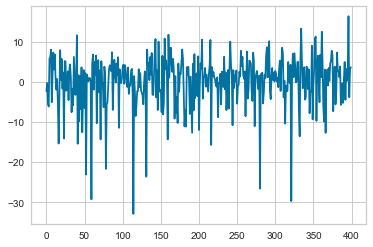

In [105]:
X_train["Percentage"].plot()

The limits we are going to use are: -4 and 4

In [114]:
def get_label(x):
    labels = ["Very bad", "Bad", "Neutral", "Good", "Very good"]
    if x < -6:
        return labels[0]
    elif x < -1:
        return labels[1]
    elif x < 1:
        return labels[2]
    elif x < 6:
        return labels[3]
    else:
        return labels[4]

In [129]:
def get_label(x):
    labels = ["Bad", "Neutral", "Good"]
    if x < -4:
        return labels[0]
    elif x < 4:
        return labels[1]
    else:
        return labels[2]

In [131]:
X_train["Percentage"] = X_train["Percentage"].apply(get_label)
X_test["Percentage"] = X_test["Percentage"].apply(get_label)

In [132]:
X_train["Percentage"].value_counts()

Neutral    225
Good        95
Bad         80
Name: Percentage, dtype: int64

Now we will use a classification model and see the results, using:
1. All the information
2. Only clusters

### 3.1 All the information

In [133]:
class_data_1 = X_train.copy()
class_data_1.drop("Pivot_value", axis=1, inplace=True)

In [134]:
clf1 = pycaret.classification.setup(class_data_1, target = "Percentage", remove_perfect_collinearity=False)

,Description,Value
0,session_id,2051
1,Target,Percentage
2,Target Type,Multiclass
3,Label Encoded,"Bad: 0, Good: 1, Neutral: 2"
4,Original Data,"(400, 42)"
5,Missing Values,False
6,Numeric Features,40
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [135]:
best_class = pycaret.classification.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.5771,0.5296,0.3725,0.4999,0.4483,0.0766,0.1614,0.0040
et,Extra Trees Classifier,0.5697,0.6247,0.4077,0.4893,0.4909,0.1381,0.1651,0.1630
rf,Random Forest Classifier,0.5483,0.5903,0.3783,0.4679,0.4612,0.0803,0.1029,0.1820
gbc,Gradient Boosting Classifier,0.5196,0.5815,0.4110,0.4751,0.4856,0.1345,0.1474,0.1370
lr,Logistic Regression,0.4983,0.5375,0.3692,0.4605,0.4561,0.0701,0.0739,0.0170
lightgbm,Light Gradient Boosting Machine,0.4942,0.6047,0.3676,0.4561,0.4567,0.0705,0.0804,0.0240
ridge,Ridge Classifier,0.4909,0.0000,0.3740,0.4475,0.4537,0.0751,0.0792,0.0040
lda,Linear Discriminant Analysis,0.4767,0.5142,0.3754,0.4613,0.4585,0.0779,0.0802,0.0050
svm,SVM - Linear Kernel,0.4759,0.0000,0.3557,0.4098,0.4031,0.0331,0.0368,0.0270
knn,K Neighbors Classifier,0.4657,0.5380,0.3864,0.4532,0.4550,0.0745,0.0746,0.0500


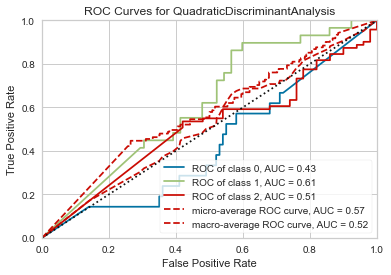

In [136]:
pycaret.classification.plot_model(best_class)

In [137]:
pycaret.classification.evaluate_model(best_class)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

### 3.2 Only clustering information

In [138]:
class_data_2 = X_train[["Cluster", "Percentage"]]

In [139]:
clf2 = pycaret.classification.setup(class_data_2, target = "Percentage", remove_perfect_collinearity=False)

,Description,Value
0,session_id,1761
1,Target,Percentage
2,Target Type,Multiclass
3,Label Encoded,"Bad: 0, Good: 1, Neutral: 2"
4,Original Data,"(400, 2)"
5,Missing Values,False
6,Numeric Features,0
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [140]:
best_class_2 = pycaret.classification.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5877,0.5285,0.3965,0.4483,0.4883,0.1318,0.1775,0.0140
ridge,Ridge Classifier,0.5877,0.0000,0.3965,0.4483,0.4883,0.1318,0.1775,0.0040
gbc,Gradient Boosting Classifier,0.5877,0.5251,0.3965,0.4483,0.4883,0.1318,0.1775,0.0340
ada,Ada Boost Classifier,0.5734,0.5247,0.3915,0.4340,0.4781,0.1151,0.1491,0.0200
rf,Random Forest Classifier,0.5663,0.5338,0.3838,0.4379,0.4756,0.1072,0.1446,0.1710
lightgbm,Light Gradient Boosting Machine,0.5663,0.5358,0.3333,0.3208,0.4095,0.0000,0.0000,0.0090
lda,Linear Discriminant Analysis,0.5591,0.5305,0.3797,0.4289,0.4706,0.0967,0.1263,0.0040
dt,Decision Tree Classifier,0.5556,0.5266,0.3775,0.4266,0.4679,0.0917,0.1202,0.0040
et,Extra Trees Classifier,0.5556,0.5266,0.3775,0.4266,0.4679,0.0917,0.1202,0.1700
svm,SVM - Linear Kernel,0.4730,0.0000,0.3644,0.4393,0.4262,0.0532,0.0613,0.0280


In [141]:
pycaret.classification.evaluate_model(best_class_2)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…